# PolyaStrength parameter grid search

**Purpose**: To identify the optimal PolyaStrength parameters in *S. cerevisiae* using a parameter grid search.


In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%run -i notebook_setup.py

## IMPORTS AND SETUP

In [4]:
PROJECT   = "/projects/b1080/eks/polyadenylation/yeast"
OUTDIR    = os.path.join(PROJECT, 'manuscript', 'analysis', 'polyastrength_model_gridsearch')
RESOURCES = os.path.join(os.path.dirname(OUTDIR), 'resources')
os.makedirs(OUTDIR, exist_ok = True)


In [5]:
boxplot_format = {
    'boxprops'     : {'edgecolor' : 'black', 'linewidth' : 0.5},
    'medianprops'  : {'color' : 'black', 'linewidth' : 0.5},
    'whiskerprops' : {'color' : 'black', 'linewidth' : 0.5},
    'capprops'     : {'color' : 'black', 'linewidth' : 0.5},
    'flierprops'   : {'color' : 'black'},
    'showfliers'   : False
}

barplot_format = {
    'color'     : 'gray',
    'edgecolor' : 'black',
    'linewidth' : 0.5
}


## HELPER FUNCTIONS

In [6]:
def compare_configuration(row, config):
    return all([(row[var] == config[var]) for var in config.keys()])


In [7]:
def visualize_parameter_effects(species, data, base_model, test_var, test_val = None, test_order = None, control_seed = 'negative_seed', replicates = 5, xlab_type = None, rotate_labels = False, auc_ylim = (0,1), auc_line = None, corr_ylim = (0,1), show_data = True):
    
    ## Filter equivalent models with the single parameter varied
    
    constant_vars = [_ for _ in base_model.keys() if (_ != test_var)]
    
    cond_mat = np.zeros((len(data), len(constant_vars)))
    
    for i,v in enumerate(constant_vars):
        cond_mat[:,i] = (data[v] == base_model[v])
        
    cond = np.all(cond_mat, axis = 1)
    dt = data.loc[cond].copy()
    
    if (test_order is not None):
        dt = dt.loc[dt[test_var].isin(test_order)].copy()
    
    if (xlab_type is not None):
        dt[test_var] = dt[test_var].astype(xlab_type)
    
    ## Confirm that all replicates were successfully included
    
    if not (dt.groupby(test_var).size() == replicates).all():
        raise ValueError("Incorrect number of replicates found for test parameters:" + str(dt.groupby(test_var).size()))
        
    if not (dt.groupby([test_var,control_seed]).size() == 1).all():
        raise ValueError("More than one model found per parameter+negative seed combination:" + str(dt.groupby([test_var,control_seed]).size()))
        
    ## Highlight selected parameter bar
    
    if (test_val is not None):
        dt['highlight'] = (dt[test_var] == test_val)
    else:
        dt['highlight'] = False
    
    ## Visualize model pair site AUROC
    
    nlevels = dt[test_var].nunique()
    norder = test_order if (test_order is not None) else sorted(dt[test_var].unique().tolist())
    
    fig,ax = plt.subplots(1,1, figsize = (0.3+(0.15*nlevels),1.5))
    
    sns.barplot(data = dt, x = test_var, y = 'val_pair_mix_auroc_mean', order = norder, 
                hue = 'highlight', palette = {False: 'lightgray', True: 'firebrick'}, 
                dodge = False, ax = ax, **barplot_format)
    
    if (test_val is not None) and (auc_line is not None):
        mean_val = dt.loc[dt[test_var] == test_val, 'val_pair_mix_auroc_mean'].agg(auc_line)
        ax.axhline(mean_val, color = 'red', linewidth = 0.5, zorder = 2)
        
    if (rotate_labels):
        ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, va = 'top', ha = 'right')
        
    ax.set_ylim(auc_ylim)
    ax.yaxis.set_major_locator(MultipleLocator(0.1))
    
    ax.set_xlabel(test_var.replace("_"," ").capitalize())
    ax.set_ylabel("AUROC")
    
    ax.get_legend().remove()

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    plt.savefig(os.path.join(OUTDIR, f'polyastrength_grid_search.{species}.{test_var}.auroc.svg'), format = 'svg', dpi = 600)
    plt.show()
    
    if (show_data):
        print("\nCorresponding data:")
        summary_data = dt.groupby(test_var)['val_pair_mix_auroc_mean'].agg([auc_line,'std']).sort_values(auc_line, ascending = False)
        summary_data['se'] = summary_data['std'] / np.sqrt(replicates)
        summary_data['within1se'] = summary_data[auc_line].apply(lambda x : '*' if (x > (summary_data.loc[summary_data[auc_line].idxmax(), auc_line] - summary_data.loc[summary_data[auc_line].idxmax(), 'se'])) else '')
        print(summary_data)
    
    ## Tests for differences in AUROC
    
    if (test_val is not None) and (auc_line is not None):
        print("\nT-test for differences in AUROC:")
        ref_auc = dt.loc[dt[test_var] == test_val, 'val_pair_mix_auroc_mean'].tolist()
        for v in norder:
            if (v != test_val):
                alt_auc = dt.loc[dt[test_var] == v, 'val_pair_mix_auroc_mean'].tolist()
                alt_pval = st.ttest_ind(ref_auc, alt_auc)[1]
                print(f"{v:4} vs {test_val:4} AUROC: pval = {alt_pval:.02E}")
    
    ## Visualize correlation between observed and predicted relative strength 
    
    fig,ax = plt.subplots(1,1, figsize = (0.3+(0.15*nlevels),1.5))
    
    sns.barplot(data = dt, x = test_var, y = 'valcorr', order = norder, 
                hue = 'highlight', palette = {False: 'lightgray', True: 'firebrick'}, 
                dodge = False, ax = ax, **barplot_format)
    
    if (test_val is not None) and (auc_line):
        mean_val = dt.loc[dt[test_var] == test_val, 'valcorr'].agg(auc_line)
        ax.axhline(mean_val, color = 'red', linewidth = 0.5, zorder = 2)
        
    if (rotate_labels):
        ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, va = 'top', ha = 'right')
        
    ax.set_ylim(corr_ylim)
    ax.yaxis.set_major_locator(MultipleLocator(0.1))
    
    ax.set_xlabel(test_var.replace("_"," ").capitalize())
    ax.set_ylabel("Correlation")
    
    ax.get_legend().remove()

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    plt.savefig(os.path.join(OUTDIR, f'polyastrength_grid_search.{species}.{test_var}.valcorr.svg'), format = 'svg', dpi = 600)
    plt.show()
    
    if (show_data):
        print("\nCorresponding data:")
        summary_data = dt.groupby(test_var)['valcorr'].agg([auc_line,'std']).sort_values(auc_line, ascending = False)
        summary_data['se'] = summary_data['std'] / np.sqrt(replicates)
        summary_data['within1se'] = summary_data[auc_line].apply(lambda x : '*' if (x > (summary_data.loc[summary_data[auc_line].idxmax(), auc_line] - summary_data.loc[summary_data[auc_line].idxmax(), 'se'])) else '')
        print(summary_data)
    
    ## Tests for differences in correlation
    
    if (test_val is not None) and (auc_line is not None):
        print("\nT-test for differences in valcorr:")
        ref_auc = dt.loc[dt[test_var] == test_val, 'valcorr'].tolist()
        for v in norder:
            if (v != test_val):
                alt_auc = dt.loc[dt[test_var] == v, 'valcorr'].tolist()
                alt_pval = st.ttest_ind(ref_auc, alt_auc)[1]
                print(f"{v:4} vs {test_val:4} valcorr: pval = {alt_pval:.02E}")

    return


In [8]:
## Cartesian product example code from: https://www.geeksforgeeks.org/cartesian-product-of-any-number-of-sets/

def cartesianProduct(set_a, set_b):
    result =[]
    for i in range(0, len(set_a)):
        for j in range(0, len(set_b)):
 
            # for handling case having cartesian
            # product first time of two sets
            if type(set_a[i]) != list:         
                set_a[i] = [set_a[i]]
                 
            # copying all the members
            # of set_a to temp
            temp = [num for num in set_a[i]]
             
            # add member of set_b to 
            # temp to have cartesian product     
            temp.append(set_b[j])             
            result.append(temp)  
             
    return result
 
# Function to do a cartesian 
# product of N sets 
def Cartesian(list_a):
     
    # result of cartesian product
    # of all the sets taken two at a time
    temp = list_a[0]
     
    # do product of N sets 
    for i in range(1, len(list_a)):
        temp = cartesianProduct(temp, list_a[i])
         
    return temp


In [9]:
def visualize_combination_effects(species, data, base_model, test_vars, test_vals = None, test_orders = None, control_seed = 'negative_seed', replicates = 5, xlab_types = None, rotate_labels = False, auc_ylim = (0,1), auc_line = None, corr_ylim = (0,1), show_data = True):
    
    ## Filter equivalent models with the combination parameters varied
    
    constant_vars = [_ for _ in base_model.keys() if (_ not in test_vars)]
    
    cond_mat = np.zeros((len(data), len(constant_vars)))
    
    for i,v in enumerate(constant_vars):
        cond_mat[:,i] = (data[v] == base_model[v])
        
    cond = np.all(cond_mat, axis = 1)
    dt = data.loc[cond].copy()
    
    if (xlab_types is not None):
        for (test_var,xlab_type) in zip(test_vars,xlab_types):
            dt[test_var] = dt[test_var].astype(xlab_type)
            
    dt['label'] = dt.apply(lambda row : "-".join([str(row[t]) for t in test_vars]), axis = 1)
    
    ## Confirm that all replicates were successfully included
    
    if not (dt.groupby(test_vars).size() == replicates).all():
        raise ValueError("Incorrect number of replicates found for test parameters:" + str(dt.groupby(test_vars).size()))
        
    if not (dt.groupby(test_vars + [control_seed]).size() == 1).all():
        raise ValueError("More than one model found per parameter+negative seed combination:" + str(dt.groupby(test_vars + [control_seed]).size()))
        
    ## Highlight selected parameter bar
    
    if (test_vals is not None):
        dt['highlight'] = (dt['label'] == test_vals)
    else:
        dt['highlight'] = False
    
    ## Visualize model receiver-operating characteristic curve
    
    nlevels = len(dt[test_vars].drop_duplicates())
    
    if (test_orders is not None):
        norder = test_orders
    else:
        norder = ["-".join(_) for _ in Cartesian([dt[test_var].sort_values().unique().astype(str).tolist() for test_var in test_vars]) if ("-".join(_) in dt['label'].unique().tolist())]
    
    fig,ax = plt.subplots(1,1, figsize = (0.3+(0.15*nlevels),1.5))
    
    sns.barplot(data = dt, x = 'label', y = 'val_pair_mix_auroc_mean', order = norder, 
                hue = 'highlight', palette = {False: 'lightgray', True: 'firebrick'}, 
                dodge = False, ax = ax, **barplot_format)
    
    if (test_vals is not None) and (auc_line is not None):
        mean_val = dt.loc[dt['label'] == test_vals, 'val_pair_mix_auroc_mean'].agg(auc_line)
        ax.axhline(mean_val, color = 'red', linewidth = 0.5, zorder = 2)
        
    if (rotate_labels):
        ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, va = 'top', ha = 'right')
        
    ax.set_ylim(auc_ylim)
    ax.yaxis.set_major_locator(MultipleLocator(0.1))
    
    ax.set_xlabel("-".join([test_var.replace("_"," ").capitalize() for test_var in test_vars]))
    ax.set_ylabel("AUROC")
    
    ax.get_legend().remove()

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    plt.savefig(os.path.join(OUTDIR, f'polyastrength_grid_search.{species}.{test_var}.auroc.svg'), format = 'svg', dpi = 600)
    plt.show()
    
    if (show_data):
        print("\nCorresponding data:")
        summary_data = dt.groupby('label')['val_pair_mix_auroc_mean'].agg([auc_line,'std']).sort_values(auc_line, ascending = False)
        summary_data['se'] = summary_data['std'] / np.sqrt(replicates)
        summary_data['within1se'] = summary_data[auc_line].apply(lambda x : '*' if (x > (summary_data.loc[summary_data[auc_line].idxmax(), auc_line] - summary_data.loc[summary_data[auc_line].idxmax(), 'se'])) else '')
        print(summary_data)
    
    ## Tests for differences in AUROC
    
    if (test_vals is not None) and (auc_line is not None):
        print("\nT-test for differences in AUROC:")
        ref_auc = dt.loc[dt['label'] == test_vals, 'val_pair_mix_auroc_mean'].tolist()
        for v in norder:
            if (v != test_vals):
                alt_auc = dt.loc[dt['label'] == v, 'val_pair_mix_auroc_mean'].tolist()
                alt_pval = st.ttest_ind(ref_auc, alt_auc)[1]
                print(f"{v:4} vs {test_vals:4} AUROC: pval = {alt_pval:.02E}")
    
    ## Visualize correlation between observed and predicted relative strength 
    
    fig,ax = plt.subplots(1,1, figsize = (0.3+(0.15*nlevels),1.5))
    
    sns.barplot(data = dt, x = 'label', y = 'valcorr', order = norder, 
                hue = 'highlight', palette = {False: 'lightgray', True: 'firebrick'}, 
                dodge = False, ax = ax, **barplot_format)
    
    if (test_vals is not None) and (auc_line is not None):
        mean_val = dt.loc[dt['label'] == test_vals, 'valcorr'].agg(auc_line)
        ax.axhline(mean_val, color = 'red', linewidth = 0.5, zorder = 2)
        
    if (rotate_labels):
        ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, va = 'top', ha = 'right')
        
    ax.set_ylim(corr_ylim)
    ax.yaxis.set_major_locator(MultipleLocator(0.1))
    
    ax.set_xlabel("-".join([test_var.replace("_"," ").capitalize() for test_var in test_vars]))
    ax.set_ylabel("Correlation")
    
    ax.get_legend().remove()

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    plt.savefig(os.path.join(OUTDIR, f'polyastrength_grid_search.{species}.{test_var}.valcorr.svg'), format = 'svg', dpi = 600)
    plt.show()
    
    if (show_data):
        print("\nCorresponding data:")
        summary_data = dt.groupby('label')['valcorr'].agg([auc_line,'std']).sort_values(auc_line, ascending = False)
        summary_data['se'] = summary_data['std'] / np.sqrt(replicates)
        summary_data['within1se'] = summary_data[auc_line].apply(lambda x : '*' if (x > (summary_data.loc[summary_data[auc_line].idxmax(), auc_line] - summary_data.loc[summary_data[auc_line].idxmax(), 'se'])) else '')
        print(summary_data)
    
    ## Tests for differences in correlation
    
    if (test_vals is not None) and (auc_line is not None):
        print("\nT-test for differences in validation correlation:")
        ref_auc = dt.loc[dt['label'] == test_vals, 'valcorr'].tolist()
        for v in norder:
            if (v != test_vals):
                alt_auc = dt.loc[dt['label'] == v, 'valcorr'].tolist()
                alt_pval = st.ttest_ind(ref_auc, alt_auc)[1]
                print(f"{v:4} vs {test_vals:4} valcorr: pval = {alt_pval:.02E}")
                
    return


## ANALYSIS

### Saccharomyces cerevisiae

In [10]:
grid_values = {
    'sequence_size'   : [500],
    'output_variable' : ['raw_sum_logit','raw_max_logit','raw_den_logit','scaled_sum_logit','scaled_max_logit','scaled_den_logit','after_sum_logit','after_max_logit','after_den_logit'],
    'loss_function'   : ['huber_loss','mean_squared_error'],
    'architecture'    : ['rs-small','rs-small1','rs-small2','rs-small3','rs-small4','rs-small5','rs-small6'],
    'conv_units'      : [64,128,256,512],
    'lstm_units'      : [16,32,64,128],
    'conv_shape'      : [4,6,8,10,12,14,16],
    'conv_dropout'    : [0.1,0.3,0.5,0.7],
    'dense_dropout'   : [0.1,0.3,0.5,0.7],
}

len(Cartesian([v for k,v in grid_values.items()]))


225792

In [11]:
base_model = {
    'architecture'    : 'rs-small3',
    'sequence_size'   : 500,
    'conv_units'      : 128,
    'lstm_units'      : 32,
    'conv_shape'      : 8,
    'conv_dropout'    : 0.3,
    'dense_dropout'   : 0.1,
    'learning_rate'   : 0.001,
    'loss_function'   : 'mean_squared_error',
    'output_variable' : 'raw_den_logit',
}


#### Parameter grid search

In [12]:
scer_grid = pd.read_csv(os.path.join(RESOURCES, 'polyastrength_replicate_summary.2024052.saccharomyces_cerevisiae.txt'), sep = "\t")
scer_grid = scer_grid.loc[scer_grid['modeltype'] == 'imbalgrid'].copy()

scer_grid['valprob_range'] = scer_grid['valprob_max'] - scer_grid['valprob_min']
scer_grid['kfold'] = scer_grid['dataset'].apply(lambda x : int(x.replace(".txt","").split("kfold_")[-1]))

print(scer_grid.shape)


(350, 32)


#### Using CLUSTER reads output

In [13]:
cluster_config = copy.copy(base_model)
cluster_config['score_field'] = 'cluster_reads'

print("Reference configuration for this section:")
print(cluster_config)


Reference configuration for this section:
{'architecture': 'rs-small3', 'sequence_size': 500, 'conv_units': 128, 'lstm_units': 32, 'conv_shape': 8, 'conv_dropout': 0.3, 'dense_dropout': 0.1, 'learning_rate': 0.001, 'loss_function': 'mean_squared_error', 'output_variable': 'raw_den_logit', 'score_field': 'cluster_reads'}


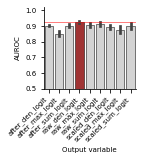


Corresponding data:
                     mean       std        se within1se
output_variable                                        
raw_den_logit     0.92436  0.006957  0.003111         *
raw_sum_logit     0.91330  0.016095  0.007198          
raw_max_logit     0.90636  0.015578  0.006967          
after_sum_logit   0.90284  0.011808  0.005281          
after_den_logit   0.90192  0.003458  0.001546          
scaled_sum_logit  0.90180  0.022275  0.009962          
scaled_den_logit  0.89402  0.014127  0.006318          
scaled_max_logit  0.87396  0.027916  0.012484          
after_max_logit   0.85070  0.021371  0.009557          

T-test for differences in AUROC:
after_den_logit vs raw_den_logit AUROC: pval = 1.96E-04
after_max_logit vs raw_den_logit AUROC: pval = 8.16E-05
after_sum_logit vs raw_den_logit AUROC: pval = 7.95E-03
raw_max_logit vs raw_den_logit AUROC: pval = 4.60E-02
raw_sum_logit vs raw_den_logit AUROC: pval = 1.96E-01
scaled_den_logit vs raw_den_logit AUROC: pval = 2.59E

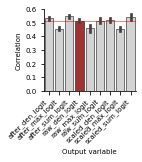


Corresponding data:
                      mean       std        se within1se
output_variable                                         
after_sum_logit   0.547528  0.015580  0.006968         *
scaled_sum_logit  0.542819  0.030243  0.013525         *
after_den_logit   0.534786  0.013714  0.006133          
scaled_den_logit  0.521163  0.017675  0.007905          
raw_sum_logit     0.515761  0.027898  0.012476          
raw_den_logit     0.515535  0.014385  0.006433          
raw_max_logit     0.458954  0.034995  0.015650          
scaled_max_logit  0.457355  0.021267  0.009511          
after_max_logit   0.455688  0.012966  0.005799          

T-test for differences in valcorr:
after_den_logit vs raw_den_logit valcorr: pval = 6.22E-02
after_max_logit vs raw_den_logit valcorr: pval = 1.23E-04
after_sum_logit vs raw_den_logit valcorr: pval = 9.73E-03
raw_max_logit vs raw_den_logit valcorr: pval = 1.02E-02
raw_sum_logit vs raw_den_logit valcorr: pval = 9.88E-01
scaled_den_logit vs raw_den_lo

In [14]:
visualize_parameter_effects('saccharomyces_cerevisiae', scer_grid, cluster_config, 
                            'output_variable', 'raw_den_logit', 
                            control_seed = 'kfold', replicates = 5, rotate_labels = True, 
                            auc_line = 'mean', auc_ylim = (0.5,1.02), corr_ylim = (0,0.6))


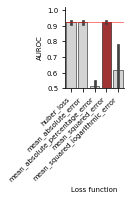


Corresponding data:
                                   mean       std        se within1se
loss_function                                                        
mean_squared_error              0.92436  0.006957  0.003111         *
huber_loss                      0.92126  0.015273  0.006830         *
mean_absolute_error             0.92114  0.010949  0.004896          
mean_squared_logarithmic_error  0.61842  0.210379  0.094084          
mean_absolute_percentage_error  0.51346  0.036590  0.016364          

T-test for differences in AUROC:
huber_loss vs mean_squared_error AUROC: pval = 6.90E-01
mean_absolute_error vs mean_squared_error AUROC: pval = 5.94E-01
mean_absolute_percentage_error vs mean_squared_error AUROC: pval = 7.79E-09
mean_squared_logarithmic_error vs mean_squared_error AUROC: pval = 1.17E-02


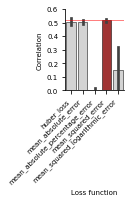


Corresponding data:
                                    mean       std        se within1se
loss_function                                                         
mean_squared_error              0.515535  0.014385  0.006433         *
huber_loss                      0.507148  0.032307  0.014448          
mean_absolute_error             0.502079  0.017851  0.007983          
mean_squared_logarithmic_error  0.148269  0.223436  0.099924          
mean_absolute_percentage_error -0.010133  0.037456  0.016751          

T-test for differences in valcorr:
huber_loss vs mean_squared_error valcorr: pval = 6.10E-01
mean_absolute_error vs mean_squared_error valcorr: pval = 2.26E-01
mean_absolute_percentage_error vs mean_squared_error valcorr: pval = 2.00E-09
mean_squared_logarithmic_error vs mean_squared_error valcorr: pval = 6.33E-03


In [15]:
visualize_parameter_effects('saccharomyces_cerevisiae', scer_grid, cluster_config, 
                            'loss_function', 'mean_squared_error', 
                            control_seed = 'kfold', replicates = 5, rotate_labels = True, 
                            auc_line = 'mean', auc_ylim = (0.5,1.02), corr_ylim = (0,0.6))


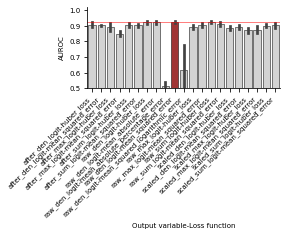


Corresponding data:
                                                 mean       std        se  \
label                                                                       
raw_den_logit-mean_squared_error              0.92436  0.006957  0.003111   
raw_sum_logit-huber_loss                      0.92372  0.011434  0.005113   
raw_den_logit-huber_loss                      0.92126  0.015273  0.006830   
raw_den_logit-mean_absolute_error             0.92114  0.010949  0.004896   
raw_sum_logit-mean_squared_error              0.91330  0.016095  0.007198   
after_den_logit-huber_loss                    0.90788  0.019792  0.008851   
raw_max_logit-mean_squared_error              0.90636  0.015578  0.006967   
after_sum_logit-huber_loss                    0.90296  0.016148  0.007221   
after_sum_logit-mean_squared_error            0.90284  0.011808  0.005281   
after_den_logit-mean_squared_error            0.90192  0.003458  0.001546   
scaled_sum_logit-mean_squared_error           0.90180  

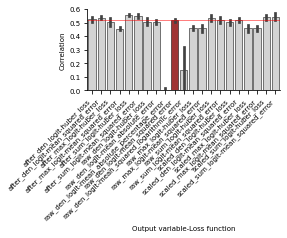


Corresponding data:
                                                  mean       std        se  \
label                                                                        
after_sum_logit-huber_loss                    0.552456  0.011524  0.005154   
after_sum_logit-mean_squared_error            0.547528  0.015580  0.006968   
scaled_sum_logit-mean_squared_error           0.542819  0.030243  0.013525   
scaled_sum_logit-huber_loss                   0.538155  0.021869  0.009780   
after_den_logit-mean_squared_error            0.534786  0.013714  0.006133   
raw_sum_logit-huber_loss                      0.532975  0.028571  0.012778   
after_den_logit-huber_loss                    0.526756  0.025663  0.011477   
scaled_den_logit-mean_squared_error           0.521163  0.017675  0.007905   
raw_sum_logit-mean_squared_error              0.515761  0.027898  0.012476   
raw_den_logit-mean_squared_error              0.515535  0.014385  0.006433   
raw_den_logit-huber_loss                   

In [16]:
visualize_combination_effects('saccharomyces_cerevisiae', scer_grid, cluster_config, 
                              ['output_variable','loss_function'], 'raw_den_logit-mean_squared_error', xlab_types = [str,str], 
                              control_seed = 'kfold', replicates = 5, rotate_labels = True, 
                              auc_line = 'mean', auc_ylim = (0.5,1.02), corr_ylim = (0,0.6))


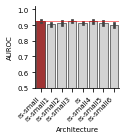


Corresponding data:
                 mean       std        se within1se
architecture                                       
rs-small      0.92636  0.008350  0.003734         *
rs-small3     0.92436  0.006957  0.003111         *
rs-small4     0.92374  0.008853  0.003959         *
rs-small2     0.91556  0.016607  0.007427          
rs            0.91454  0.006209  0.002777          
rs-small5     0.91416  0.015003  0.006710          
rs-small1     0.90616  0.011797  0.005276          
rs-small6     0.89850  0.016058  0.007182          

T-test for differences in AUROC:
rs-small1 vs rs-small AUROC: pval = 1.41E-02
rs-small2 vs rs-small AUROC: pval = 2.30E-01
rs-small3 vs rs-small AUROC: pval = 6.92E-01
rs   vs rs-small AUROC: pval = 3.47E-02
rs-small4 vs rs-small AUROC: pval = 6.43E-01
rs-small5 vs rs-small AUROC: pval = 1.51E-01
rs-small6 vs rs-small AUROC: pval = 8.80E-03


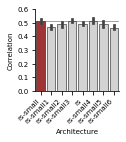


Corresponding data:
                  mean       std        se within1se
architecture                                        
rs-small4     0.517454  0.023868  0.010674         *
rs-small3     0.515535  0.014385  0.006433         *
rs-small      0.514002  0.018865  0.008437         *
rs            0.493479  0.012018  0.005374          
rs-small5     0.493303  0.027554  0.012323          
rs-small2     0.488317  0.024466  0.010942          
rs-small1     0.473232  0.021151  0.009459          
rs-small6     0.465385  0.019877  0.008889          

T-test for differences in valcorr:
rs-small1 vs rs-small valcorr: pval = 1.23E-02
rs-small2 vs rs-small valcorr: pval = 1.00E-01
rs-small3 vs rs-small valcorr: pval = 8.89E-01
rs   vs rs-small valcorr: pval = 7.43E-02
rs-small4 vs rs-small valcorr: pval = 8.06E-01
rs-small5 vs rs-small valcorr: pval = 2.03E-01
rs-small6 vs rs-small valcorr: pval = 4.14E-03


In [17]:
visualize_parameter_effects('saccharomyces_cerevisiae', scer_grid, cluster_config, 
                            'architecture', 'rs-small', ['rs-small','rs-small1','rs-small2','rs-small3','rs','rs-small4','rs-small5','rs-small6'],
                            control_seed = 'kfold', replicates = 5, rotate_labels = True, 
                            auc_line = 'mean', auc_ylim = (0.5,1.02), corr_ylim = (0,0.6))


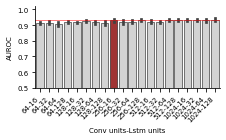


Corresponding data:
             mean       std        se within1se
label                                          
1024-128  0.93394  0.010215  0.004568         *
1024-32   0.93188  0.006260  0.002800         *
256-128   0.93182  0.009017  0.004032         *
1024-16   0.93172  0.010786  0.004824         *
512-64    0.93072  0.008580  0.003837         *
512-128   0.93052  0.008925  0.003991         *
256-16    0.93012  0.011597  0.005186         *
1024-64   0.93000  0.011284  0.005046         *
128-32    0.92436  0.006957  0.003111          
256-64    0.92248  0.011333  0.005068          
256-32    0.92104  0.019089  0.008537          
128-64    0.92090  0.014024  0.006272          
512-32    0.92010  0.005980  0.002674          
512-16    0.92008  0.015679  0.007012          
64-128    0.91764  0.010613  0.004746          
128-16    0.91690  0.003821  0.001709          
128-128   0.91522  0.018627  0.008330          
64-32     0.91384  0.012871  0.005756          
64-16     0.91292  

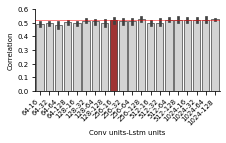


Corresponding data:
              mean       std        se within1se
label                                           
256-128   0.526465  0.018146  0.008115         *
1024-128  0.525344  0.007682  0.003435         *
1024-64   0.524393  0.024102  0.010779         *
512-128   0.524070  0.022155  0.009908         *
512-64    0.523457  0.014652  0.006552         *
1024-16   0.522615  0.018434  0.008244         *
1024-32   0.521094  0.021638  0.009677         *
256-16    0.517733  0.020823  0.009312          
128-32    0.515535  0.014385  0.006433          
256-32    0.512702  0.020305  0.009081          
256-64    0.510578  0.025545  0.011424          
128-64    0.510063  0.018020  0.008059          
64-128    0.504061  0.015333  0.006857          
512-32    0.501461  0.028122  0.012577          
128-128   0.499771  0.027131  0.012133          
512-16    0.499142  0.021744  0.009724          
128-16    0.496312  0.017853  0.007984          
64-32     0.495853  0.013053  0.005838          

In [18]:
visualize_combination_effects('saccharomyces_cerevisiae', scer_grid, cluster_config, 
                              ['conv_units','lstm_units'], '256-16', xlab_types = [int,int], 
                              control_seed = 'kfold', replicates = 5, rotate_labels = True, 
                              auc_line = 'mean', auc_ylim = (0.5,1.02), corr_ylim = (0,0.6))


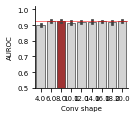


Corresponding data:
               mean       std        se within1se
conv_shape                                       
8.0         0.92436  0.006957  0.003111         *
16.0        0.92374  0.006268  0.002803         *
20.0        0.92350  0.008236  0.003683         *
6.0         0.92296  0.008337  0.003728         *
12.0        0.92114  0.008721  0.003900          
14.0        0.92112  0.013029  0.005827          
18.0        0.91784  0.012781  0.005716          
10.0        0.91254  0.012837  0.005741          
4.0         0.90160  0.007170  0.003206          

T-test for differences in AUROC:
 4.0 vs    8 AUROC: pval = 9.36E-04
 6.0 vs    8 AUROC: pval = 7.80E-01
10.0 vs    8 AUROC: pval = 1.08E-01
12.0 vs    8 AUROC: pval = 5.37E-01
14.0 vs    8 AUROC: pval = 6.37E-01
16.0 vs    8 AUROC: pval = 8.86E-01
18.0 vs    8 AUROC: pval = 3.46E-01
20.0 vs    8 AUROC: pval = 8.63E-01


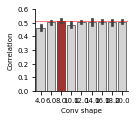


Corresponding data:
                mean       std        se within1se
conv_shape                                        
8.0         0.515535  0.014385  0.006433         *
20.0        0.509570  0.011918  0.005330         *
16.0        0.508176  0.014606  0.006532          
14.0        0.507873  0.025279  0.011305          
6.0         0.505523  0.019387  0.008670          
12.0        0.505103  0.006689  0.002991          
18.0        0.504347  0.023477  0.010499          
10.0        0.484486  0.021018  0.009400          
4.0         0.465670  0.023245  0.010395          

T-test for differences in valcorr:
 4.0 vs    8 valcorr: pval = 3.54E-03
 6.0 vs    8 valcorr: pval = 3.81E-01
10.0 vs    8 valcorr: pval = 2.60E-02
12.0 vs    8 valcorr: pval = 1.80E-01
14.0 vs    8 valcorr: pval = 5.72E-01
16.0 vs    8 valcorr: pval = 4.45E-01
18.0 vs    8 valcorr: pval = 3.90E-01
20.0 vs    8 valcorr: pval = 4.96E-01


In [19]:
visualize_parameter_effects('saccharomyces_cerevisiae', scer_grid, cluster_config, 
                            'conv_shape', 8, replicates = 5, control_seed = 'kfold', 
                            auc_line = 'mean', auc_ylim = (0.5,1.02), corr_ylim = (0,0.6))


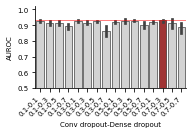


Corresponding data:
            mean       std        se within1se
label                                         
0.7-0.3  0.93100  0.008940  0.003998         *
0.5-0.5  0.92848  0.006325  0.002829         *
0.1-0.1  0.92706  0.005546  0.002480         *
0.5-0.3  0.92650  0.014148  0.006327          
0.3-0.1  0.92436  0.006957  0.003111          
0.3-0.5  0.92406  0.005561  0.002487          
0.7-0.1  0.92090  0.009330  0.004173          
0.5-0.1  0.92020  0.011614  0.005194          
0.7-0.5  0.91676  0.035625  0.015932          
0.1-0.3  0.91648  0.015615  0.006983          
0.3-0.3  0.91556  0.013206  0.005906          
0.1-0.5  0.91526  0.013024  0.005824          
0.5-0.7  0.90250  0.024096  0.010776          
0.1-0.7  0.89310  0.023619  0.010563          
0.7-0.7  0.88550  0.042378  0.018952          
0.3-0.7  0.86526  0.045007  0.020128          

T-test for differences in AUROC:
0.1-0.1 vs 0.7-0.3 AUROC: pval = 4.27E-01
0.1-0.3 vs 0.7-0.3 AUROC: pval = 1.09E-01
0.1-0.5 vs 0.7-

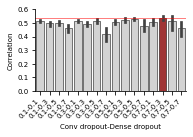


Corresponding data:
             mean       std        se within1se
label                                          
0.7-0.3  0.535891  0.016894  0.007555         *
0.5-0.5  0.526855  0.007803  0.003490          
0.5-0.3  0.521679  0.019085  0.008535          
0.3-0.1  0.515535  0.014385  0.006433          
0.1-0.1  0.513293  0.011548  0.005164          
0.7-0.5  0.512236  0.069932  0.031275          
0.3-0.5  0.511675  0.018718  0.008371          
0.7-0.1  0.508558  0.025388  0.011354          
0.5-0.1  0.504867  0.017511  0.007831          
0.1-0.5  0.496997  0.023494  0.010507          
0.1-0.3  0.495984  0.017182  0.007684          
0.3-0.3  0.490617  0.016038  0.007172          
0.5-0.7  0.479632  0.047234  0.021124          
0.1-0.7  0.463593  0.035250  0.015764          
0.7-0.7  0.462311  0.063309  0.028313          
0.3-0.7  0.417298  0.062187  0.027811          

T-test for differences in validation correlation:
0.1-0.1 vs 0.7-0.3 valcorr: pval = 3.88E-02
0.1-0.3 vs 0.7-0.3 v

In [20]:
visualize_combination_effects('saccharomyces_cerevisiae', scer_grid, cluster_config, 
                              ['conv_dropout','dense_dropout'], '0.7-0.3', xlab_types = [float,float], 
                              control_seed = 'kfold', replicates = 5, rotate_labels = True, 
                              auc_line = 'mean', auc_ylim = (0.5,1.02), corr_ylim = (0,0.6))


#### Best configuration

In [21]:
scer_reps = pd.read_csv(os.path.join(RESOURCES, 'polyastrength_replicate_summary.2024052.saccharomyces_cerevisiae.txt'), sep = "\t")
scer_reps = scer_reps.loc[(scer_reps['modeltype'] == 'configs')].copy()

scer_reps['valprob_range'] = scer_reps['valprob_max'] - scer_reps['valprob_min']

print(scer_reps.shape)


(60, 31)


In [22]:
scer_reps.sort_values('val_pair_mix_auroc_mean', ascending = False).head()


,species,stamp,dataset,genomic_As,train_sites,negative_seed,split_seed,modeltype,loss_function,score_field,...,valcorr,valprob_min,valprob_max,val_pair_top_count_mean,val_pair_top_auroc_mean,val_pair_top_auroc_std,val_pair_mix_count_mean,val_pair_mix_auroc_mean,val_pair_mix_auroc_std,valprob_range
385,saccharomyces_cerevisiae,20240524-081023,/projects/b1080/eks/polyadenylation/yeast/sacc...,NaN,14488,NaN,12345,configs,mean_squared_error,cluster_reads,...,0.581783,0.016528,0.920863,470.0,0.788,0.0,334.0,0.9636,0.003441,0.904335
355,saccharomyces_cerevisiae,20240524-080805,/projects/b1080/eks/polyadenylation/yeast/sacc...,NaN,14488,NaN,12345,configs,mean_squared_error,cluster_reads,...,0.582247,0.025250,0.885682,470.0,0.782,0.0,334.0,0.9620,0.004494,0.860432
375,saccharomyces_cerevisiae,20240524-080938,/projects/b1080/eks/polyadenylation/yeast/sacc...,NaN,14488,NaN,12345,configs,mean_squared_error,cluster_reads,...,0.590188,0.041317,0.790090,470.0,0.798,0.0,334.0,0.9610,0.002898,0.748774
386,saccharomyces_cerevisiae,20240524-081030,/projects/b1080/eks/polyadenylation/yeast/sacc...,NaN,14488,NaN,12345,configs,mean_squared_error,cluster_reads,...,0.579262,0.020321,0.871603,470.0,0.791,0.0,334.0,0.9609,0.003208,0.851282
350,saccharomyces_cerevisiae,20240524-080744,/projects/b1080/eks/polyadenylation/yeast/sacc...,NaN,14488,NaN,12345,configs,mean_squared_error,cluster_reads,...,0.590842,0.041914,0.875412,470.0,0.783,0.0,334.0,0.9598,0.004578,0.833498


In [23]:
scer_reps.sort_values('valcorr', ascending = False).head()


,species,stamp,dataset,genomic_As,train_sites,negative_seed,split_seed,modeltype,loss_function,score_field,...,valcorr,valprob_min,valprob_max,val_pair_top_count_mean,val_pair_top_auroc_mean,val_pair_top_auroc_std,val_pair_mix_count_mean,val_pair_mix_auroc_mean,val_pair_mix_auroc_std,valprob_range
352,saccharomyces_cerevisiae,20240524-080751,/projects/b1080/eks/polyadenylation/yeast/sacc...,NaN,14488,NaN,12345,configs,mean_squared_error,cluster_reads,...,0.595553,0.016281,0.910899,470.0,0.789,0.0,334.0,0.9588,0.004665,0.894618
350,saccharomyces_cerevisiae,20240524-080744,/projects/b1080/eks/polyadenylation/yeast/sacc...,NaN,14488,NaN,12345,configs,mean_squared_error,cluster_reads,...,0.590842,0.041914,0.875412,470.0,0.783,0.0,334.0,0.9598,0.004578,0.833498
375,saccharomyces_cerevisiae,20240524-080938,/projects/b1080/eks/polyadenylation/yeast/sacc...,NaN,14488,NaN,12345,configs,mean_squared_error,cluster_reads,...,0.590188,0.041317,0.790090,470.0,0.798,0.0,334.0,0.9610,0.002898,0.748774
359,saccharomyces_cerevisiae,20240524-080820,/projects/b1080/eks/polyadenylation/yeast/sacc...,NaN,14488,NaN,12345,configs,mean_squared_error,cluster_reads,...,0.587311,0.022204,0.877062,470.0,0.794,0.0,334.0,0.9571,0.003618,0.854858
396,saccharomyces_cerevisiae,20240524-081115,/projects/b1080/eks/polyadenylation/yeast/sacc...,NaN,14488,NaN,12345,configs,mean_squared_error,cluster_reads,...,0.585552,0.028018,0.875002,470.0,0.789,0.0,334.0,0.9543,0.003662,0.846985


In [24]:
scer_reps.sort_values('val_pair_mix_auroc_mean', ascending = False).iloc[0]


species                                             saccharomyces_cerevisiae
stamp                                                        20240524-081023
dataset                    /projects/b1080/eks/polyadenylation/yeast/sacc...
genomic_As                                                               NaN
train_sites                                                            14488
negative_seed                                                            NaN
split_seed                                                             12345
modeltype                                                            configs
loss_function                                             mean_squared_error
score_field                                                    cluster_reads
output_variable                                                raw_den_logit
architecture                                                        rs-small
sequence_size                                                            500